# Import

In [71]:
import warnings                                                                                                #import libraries
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from time import process_time
from scipy import stats

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer

from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import accuracy_score, make_scorer, mean_absolute_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, VarianceThreshold
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

import lightgbm as lgb
from xgboost import XGBClassifier, XGBRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier as GBoost, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline

%matplotlib inline

In [2]:
df = pd.read_csv('house_price_2.csv')

In [3]:
df.head(2)

,Index,Title,Description,Amount(in rupees),Price (in rupees),location,Carpet Area,Status,Floor,Transaction,...,facing,overlooking,Society,Bathroom,Balcony,Car Parking,Ownership,Super Area,Dimensions,Plot Area
0,0,1 BHK Ready to Occupy Flat for sale in Srushti...,"Bhiwandi, Thane has an attractive 1 BHK Flat f...",42 Lac,6000.0,thane,500 sqft,Ready to Move,10 out of 11,Resale,...,NaN,NaN,Srushti Siddhi Mangal Murti Complex,1,2,NaN,NaN,NaN,NaN,NaN
1,1,2 BHK Ready to Occupy Flat for sale in Dosti V...,One can find this stunning 2 BHK flat for sale...,98 Lac,13799.0,thane,473 sqft,Ready to Move,3 out of 22,Resale,...,East,Garden/Park,Dosti Vihar,2,NaN,1 Open,Freehold,NaN,NaN,NaN


In [4]:
df.drop(['Index'], axis=1, inplace=True)
df_train = df.loc[df['Price (in rupees)'].notna()]
df_test = df.loc[df['Price (in rupees)'].isna()]

In [5]:
print('Train dataset shape: ', df_train.shape)
print('Test dataset shape:  ', df_test.shape)

Train dataset shape:  (169866, 20)
Test dataset shape:   (17665, 20)


In [6]:
df_train = df_train.sample(frac=0.1)
df_train.reset_index(inplace=True)
df_train.drop(['index'], axis=1, inplace=True)

In [7]:
print('New train dataset shape: ', df_train.shape)

New train dataset shape:  (16987, 20)


In [8]:
df = pd.concat([df_train, df_test])

In [9]:
print('Full dataset shape: ', df.shape)

Full dataset shape:  (34652, 20)


# EDA

In [10]:
df_notna = df.notna().sum()
df_notna

Title                34652
Description          34229
Amount(in rupees)    34652
Price (in rupees)    16987
location             34652
Carpet Area          22603
Status               34580
Floor                33732
Transaction          34575
Furnishing           33598
facing               20323
overlooking          16824
Society              12716
Bathroom             34484
Balcony              26210
Car Parking          13242
Ownership            21655
Super Area           11222
Dimensions               0
Plot Area                0
dtype: int64

In [11]:
na_col = np.unique(df_notna, return_counts=True)
na_col

(array([    0, 11222, 12716, 13242, 16824, 16987, 20323, 21655, 22603,
        26210, 33598, 33732, 34229, 34484, 34575, 34580, 34652]),
 array([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]))

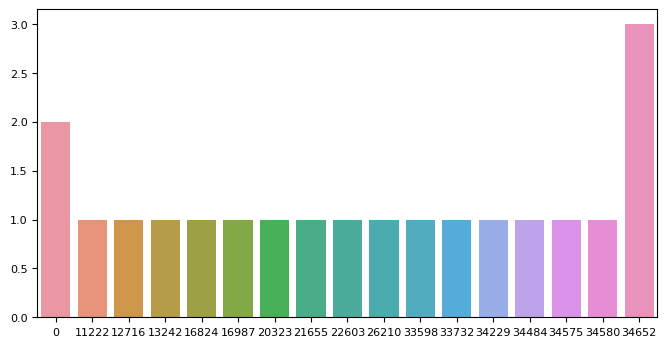

In [12]:
plt.figure(figsize=(8,4))
b = sns.barplot(x=na_col[0], y=na_col[1])
b.tick_params(labelsize=8)

In [13]:
for i in df.columns:
    if (df[i].notna().sum() < 0.5*len(df)) and (i != 'Price (in rupees)'):
        del(df[i])

In [14]:
df.shape

(34652, 14)

In [15]:
df_room_count = df['Title'].str.split(pat = ' BHK', expand = True)
df_flat_or_apartment = df['Title'].str.split(pat = ' for sale ', expand = True)
df_flat_or_apartment = df_flat_or_apartment[0].str.split(pat = 'Occupy ', expand = True)
df_flat_or_apartment[1].fillna(df_flat_or_apartment[0], inplace=True)

df_room_count = df_room_count[0]
df_flat_or_apartment = df_flat_or_apartment[1]

df = pd.concat([df, df_room_count, df_flat_or_apartment], axis=1)
df.drop(['Title'], axis=1, inplace=True)
df.rename(columns = {0:'Rooms_count', 1:'Flat_or_Apartment'}, inplace=True)

In [16]:
df.replace({'Rooms_count' : {'1': '1 ','2': '2 ','3': '3 ','4': '4 ','5': '5 ','6': '6 ','7': '7 ','8': '8 ','9': '9 ','10': '10 ','> 10': '11 '}}, inplace=True)
df_room_count = df['Rooms_count'].str.split(pat = ' ', expand = True)
df_room_count = df_room_count[0]
df = pd.concat([df, df_room_count], axis=1)
df.drop(['Rooms_count'], axis=1, inplace=True)
df.rename(columns = {0:'Rooms_count'}, inplace=True)
df[['Rooms_count']] = df[['Rooms_count']].apply(pd.to_numeric)

In [17]:
df_amount = df['Amount(in rupees)'].str.split(pat = ' ', expand = True)
df_amount_number = df_amount[0]
df_lac_or_cr = df_amount[1]
df = pd.concat([df, df_amount_number, df_lac_or_cr], axis=1)
df.drop(['Amount(in rupees)'], axis=1, inplace=True)
df.rename(columns = {0:'Amount'}, inplace=True)

In [18]:
df.replace({'Amount' : {'Call': 0}}, inplace=True)
df[['Amount']] = df[['Amount']].apply(pd.to_numeric)
df.replace({1 : {'Cr': 100, 'Lac': 1, 'for': 0}}, inplace=True)
df[[1]] = df[[1]].apply(pd.to_numeric)
df['Amount'] = df['Amount']*df[1]
df.drop([1], axis=1, inplace=True)
df.replace({'Amount' : {0 : np.NaN}}, inplace=True)

In [19]:
df_carpet_area = df['Carpet Area'].str.split(pat = ' ', expand = True)
df_carpet_area = df_carpet_area[0]
df = pd.concat([df, df_carpet_area], axis=1)
df.drop(['Carpet Area'], axis=1, inplace=True)
df.rename(columns = {0:'Carpet_area'}, inplace=True)
df[['Carpet_area']] = df[['Carpet_area']].apply(pd.to_numeric)
df['Carpet_area'].fillna(0, inplace=True)

In [20]:
df['Status'].fillna('Not Ready to Move', inplace=True)

In [21]:
df_floor = df['Floor'].str.split(pat = ' ', expand = True)
df_floors = df['Floor'].str.split(pat = 'of ', expand = True)
df_floor = df_floor[0]
df_floors = df_floors[1]
df = pd.concat([df, df_floor, df_floors], axis=1)
df.drop(['Floor'], axis=1, inplace=True)
df.rename(columns = {0:'Floor', 1:'Floors'}, inplace=True)

In [22]:
df.replace({'Floor' : {'Ground': 0, 'Lower': 0, 'Upper': df['Floors']}}, inplace=True)
df[['Floor', 'Floors']] = df[['Floor', 'Floors']].apply(pd.to_numeric)

In [23]:
df['Transaction'].fillna('Other', inplace=True)
df['Furnishing'].fillna('Unfurnished', inplace=True)

In [24]:
df.replace({'Bathroom' : {'> 10': 11}}, inplace=True)
df[['Bathroom']] = df[['Bathroom']].apply(pd.to_numeric)

In [25]:
df.replace({'Balcony' : {'> 10': 11}}, inplace=True)
df['Balcony'].fillna('0', inplace=True)
df[['Balcony']] = df[['Balcony']].apply(pd.to_numeric)

In [28]:
df_text = df['Description']
df.drop(['Description'], axis=1, inplace=True)

In [50]:
df

,Price (in rupees),location,Status,Transaction,Furnishing,facing,Bathroom,Balcony,Ownership,Flat_or_Apartment,Rooms_count,Amount,Carpet_area,Floor,Floors
0,7207.0,bangalore,Ready to Move,Resale,Semi-Furnished,NaN,2.0,0,NaN,Flat,2.0,96.0,0.0,5.0,10.0
1,3600.0,greater-noida,Ready to Move,Resale,Semi-Furnished,North - East,2.0,3,Leasehold,Flat,2.0,36.0,800.0,5.0,25.0
2,5728.0,kolkata,Ready to Move,Resale,Unfurnished,East,2.0,2,NaN,Flat,2.0,72.0,900.0,2.0,18.0
3,3007.0,ahmedabad,Ready to Move,Resale,Unfurnished,East,1.0,1,Freehold,Flat,1.0,23.0,498.0,1.0,5.0
4,12103.0,gurgaon,Ready to Move,New Property,Unfurnished,South,3.0,3,Freehold,Flat,3.0,225.0,1790.0,11.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187404,NaN,zirakpur,Ready to Move,Resale,Semi-Furnished,North,3.0,3,Freehold,Flat,3.0,NaN,1450.0,3.0,9.0
187442,NaN,zirakpur,Ready to Move,New Property,Semi-Furnished,North,3.0,2,Freehold,Flat,3.0,NaN,1200.0,2.0,4.0
187503,NaN,zirakpur,Ready to Move,New Property,Semi-Furnished,North - East,3.0,2,Co-operative Society,Flat,3.0,NaN,990.0,4.0,5.0
187506,NaN,zirakpur,Ready to Move,Resale,Furnished,East,4.0,4,Freehold,Flat,4.0,NaN,2500.0,6.0,7.0


# Categorical

In [29]:
df_g = pd.get_dummies(df, drop_first=True)
df_g.reset_index(inplace=True)
df_g.drop(['index'], axis=1, inplace=True)

In [30]:
df_g

,Price (in rupees),Bathroom,Balcony,Rooms_count,Amount,Carpet_area,Floor,Floors,location_ahmadnagar,location_ahmedabad,...,facing_South,facing_South - East,facing_South -West,facing_West,Ownership_Freehold,Ownership_Leasehold,Ownership_Power Of Attorney,Flat_or_Apartment_ Builder Floor,Flat_or_Apartment_ Studio Apartment,Flat_or_Apartment_Flat
0,7207.0,2.0,0,2.0,96.0,0.0,5.0,10.0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,3600.0,2.0,3,2.0,36.0,800.0,5.0,25.0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,5728.0,2.0,2,2.0,72.0,900.0,2.0,18.0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3007.0,1.0,1,1.0,23.0,498.0,1.0,5.0,0,1,...,0,0,0,0,1,0,0,0,0,1
4,12103.0,3.0,3,3.0,225.0,1790.0,11.0,22.0,0,0,...,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34647,NaN,3.0,3,3.0,NaN,1450.0,3.0,9.0,0,0,...,0,0,0,0,1,0,0,0,0,1
34648,NaN,3.0,2,3.0,NaN,1200.0,2.0,4.0,0,0,...,0,0,0,0,1,0,0,0,0,1
34649,NaN,3.0,2,3.0,NaN,990.0,4.0,5.0,0,0,...,0,0,0,0,0,0,0,0,0,1
34650,NaN,4.0,4,4.0,NaN,2500.0,6.0,7.0,0,0,...,0,0,0,0,1,0,0,0,0,1


# Fill in the gaps

In [31]:
df.isna().sum()

Price (in rupees)    17665
location                 0
Status                   0
Transaction              0
Furnishing               0
facing               14329
Bathroom               168
Balcony                  0
Ownership            12997
Flat_or_Apartment        0
Rooms_count            643
Amount                9684
Carpet_area              0
Floor                  920
Floors                 934
dtype: int64

In [32]:
%time
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(df_g.iloc[:,1:].values)
df_g_it = imp.transform(df_g.iloc[:,1:].values)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


In [33]:
df_g_it

array([[2.        , 0.        , 2.        , ..., 0.        , 0.        ,
        1.        ],
       [2.        , 3.        , 2.        , ..., 0.        , 0.        ,
        1.        ],
       [2.        , 2.        , 2.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [3.        , 2.        , 3.        , ..., 0.        , 0.        ,
        1.        ],
       [4.        , 4.        , 4.        , ..., 0.        , 0.        ,
        1.        ],
       [2.70322745, 0.        , 3.        , ..., 0.        , 0.        ,
        1.        ]])

In [34]:
df2 = df_g_it

In [35]:
df3 = pd.DataFrame(data=df2, columns=df_g.iloc[:,1:].columns)
df3['Price'] = df_g['Price (in rupees)']

df3.head()

,Bathroom,Balcony,Rooms_count,Amount,Carpet_area,Floor,Floors,location_ahmadnagar,location_ahmedabad,location_allahabad,...,facing_South - East,facing_South -West,facing_West,Ownership_Freehold,Ownership_Leasehold,Ownership_Power Of Attorney,Flat_or_Apartment_ Builder Floor,Flat_or_Apartment_ Studio Apartment,Flat_or_Apartment_Flat,Price
0,2.0,0.0,2.0,96.0,0.0,5.0,10.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7207.0
1,2.0,3.0,2.0,36.0,800.0,5.0,25.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3600.0
2,2.0,2.0,2.0,72.0,900.0,2.0,18.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5728.0
3,1.0,1.0,1.0,23.0,498.0,1.0,5.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3007.0
4,3.0,3.0,3.0,225.0,1790.0,11.0,22.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,12103.0


# Future selection

<Axes: >

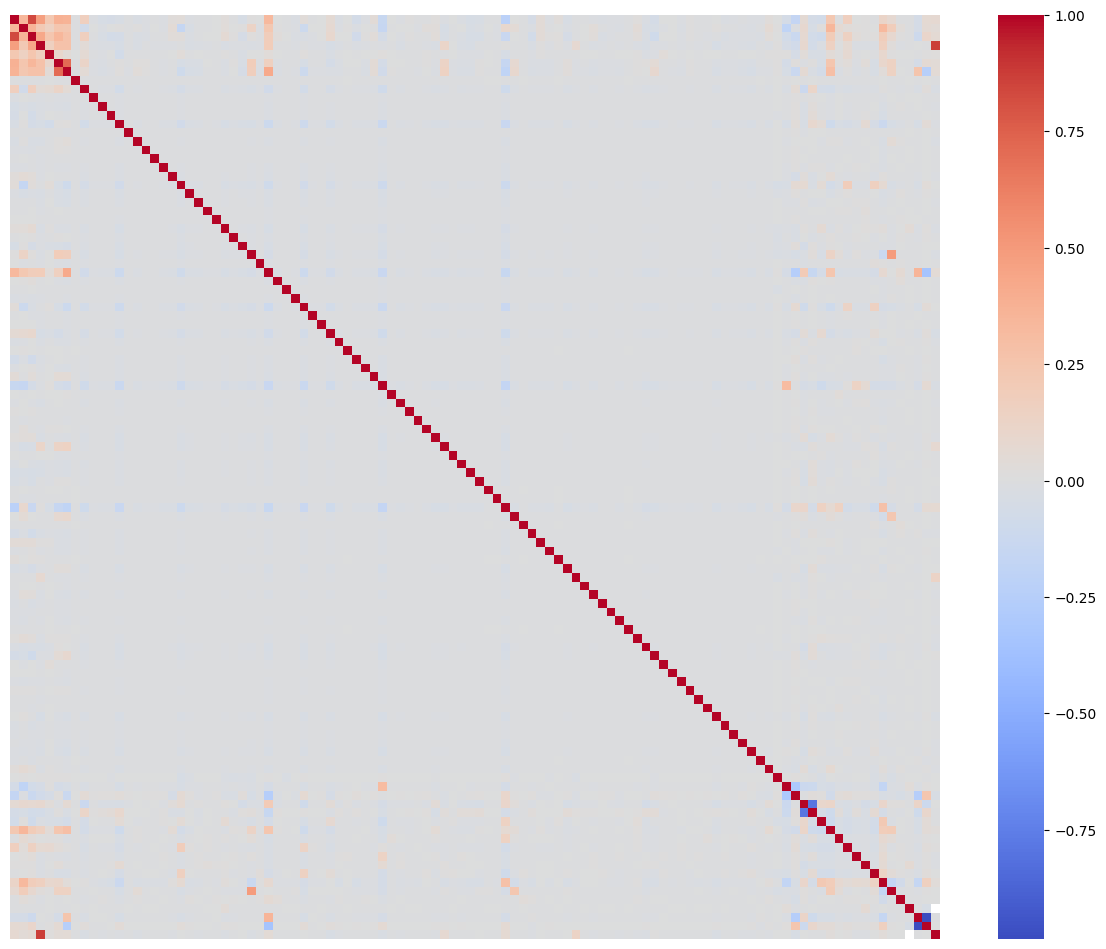

In [36]:
cor = df3.corr()

plt.figure(figsize=(15,12))
sns.heatmap(cor, xticklabels=False, yticklabels=False, cmap='coolwarm')

In [37]:
all_features = list(cor.columns)
f_to_del = []

for i in cor.columns:
    if i == 'Price':
        continue
    for j in cor.index:
        if all_features.index(j) >= all_features.index(i) or j == 'Price':
            continue
        else:
            if abs(cor.loc[i,j]) > 0.8:
                if abs(cor.loc['Price', i]) > abs(cor.loc['Price', j]):
                    f_to_del.append(j)
                else:
                    f_to_del.append(i)

In [38]:
f_to_del = set(f_to_del)
print(len(f_to_del))
f_to_del

2


{'Flat_or_Apartment_ Studio Apartment', 'Rooms_count'}

In [39]:
for i in f_to_del:
    del df3[i]

In [40]:
df3.shape

(34652, 104)

# Text category

In [41]:
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [42]:
def clean_text(text):
    text = str(text)
    text = re.sub(r'[^\w\s]','',text)
    text = text.lower()
    text_words_list = text.split(' ')
    ps = PorterStemmer()
    stemmed_words=[]
    for w in text_words_list:
        if len(w)>0:
            if w not in stopwords.words('english'):
                stemmed_words.append(ps.stem(w))
    #return stemmed_words
    return ' '.join(stemmed_words)

In [43]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [45]:
df_text

0         Sarjapur Road, Bangalore has an attractive 2 B...
1         Discover this immaculate 2 BHK flat for sale a...
2         2 BHK, Multistorey Apartment is available for ...
3         Vastral, Ahmedabad has an attractive 1 BHK Fla...
4         Discover this immaculate 3 BHK flat for sale a...
                                ...                        
187404    This gorgeous 3 BHK Flat is available for sale...
187442    Have a look at this immaculate 3 BHK flat for ...
187503    Up for immediate sale is a 3 BHK apartment in ...
187506    Carefully laid out in the prime location of Pe...
187513    This ready to move-in 3 BHK flat is available ...
Name: Description, Length: 34652, dtype: object

In [52]:
print(df_text[0])
print()
print(clean_text(df_text[0]))

df_text = df_text.apply(clean_text)

Sarjapur Road, Bangalore has an attractive 2 BHK Flat for sale. The property is ideally located in a strategic location in Divyasree Elan township. This flat for resale is just the type of property you have been searching for! This ready to move flat in Sarjapur Road can be taken at a very economical pricing of INR 96 Lac. The flat is semi-furnished and makes for an ideal choice for any family.

sarjapur road bangalor attract 2 bhk flat sale properti ideal locat strateg locat divyasre elan township flat resal type properti search readi move flat sarjapur road taken econom price inr 96 lac flat semifurnish make ideal choic famili


In [54]:
%time
print(df_text.apply(len).min())
print(df_text.apply(len).mean())
print(df_text.apply(len).max())

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs
3
225.55699526722844
1935


In [55]:
word_embeddings = {}

with open("glove.6B.100d.txt", 'r', encoding="utf-8") as f: #word2vec fasttext
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_embeddings[word] = coefs
    f.close()

In [56]:
sum([word_embeddings.get(w, np.zeros((100,))) for w in df_text[0].split()])/(len(df_text[0].split())+0.001)

array([-0.06698653,  0.09449562,  0.09837556,  0.15524321, -0.01706325,
       -0.07497655,  0.07489421,  0.22194582, -0.07415224, -0.08628691,
        0.05126076,  0.06295719,  0.02125568, -0.10898513,  0.11678733,
       -0.074057  ,  0.06434652,  0.00239586,  0.08496127,  0.14710434,
        0.23235181,  0.02677358,  0.04929053,  0.03074816,  0.03149073,
       -0.04159957,  0.02884806, -0.14566872, -0.18880208, -0.08598018,
       -0.05755554,  0.17482216,  0.02199455, -0.08454304,  0.14913989,
        0.17350338,  0.10161454,  0.04432978,  0.087886  , -0.04355596,
       -0.02218205, -0.28727378, -0.03604249, -0.19386595,  0.02271406,
        0.03636739, -0.00475893,  0.01576334, -0.0112802 , -0.24226684,
       -0.00296965, -0.07040553,  0.1192849 ,  0.3758981 , -0.16078942,
       -0.95287132, -0.07601432, -0.05468193,  0.77681195, -0.00531476,
       -0.08101611,  0.10720907, -0.08184269,  0.14602432,  0.24506408,
        0.00132423,  0.16434875,  0.0566373 ,  0.12157007, -0.15

In [57]:
def name_to_vect(name):
    if len(name) != 0:
        v = sum([word_embeddings.get(w, np.zeros((100,))) for w in name.split()])/(len(name.split())+0.001)
    else:
        v = np.zeros((100,))
    return v

In [58]:
df_text = df_text.apply(name_to_vect)

In [59]:
df = df.join(pd.DataFrame(df_text.tolist(), index = df.index))

In [60]:
df.head(2)

,Price (in rupees),location,Status,Transaction,Furnishing,facing,Bathroom,Balcony,Ownership,Flat_or_Apartment,...,90,91,92,93,94,95,96,97,98,99
0,7207.0,bangalore,Ready to Move,Resale,Semi-Furnished,NaN,2.0,0,NaN,Flat,...,-0.153348,0.112224,-0.034701,0.004446,-0.230691,-0.031445,-0.058102,-0.072853,0.348341,-0.011938
1,3600.0,greater-noida,Ready to Move,Resale,Semi-Furnished,North - East,2.0,3,Leasehold,Flat,...,-0.048425,0.013645,-0.142342,-0.085870,-0.296616,0.023683,-0.044761,-0.096470,0.382606,0.039582


# Splitting into train and test samples

In [63]:
train = df3[:16987]
test = df3[16987:]
test.drop(['Price'], axis=1, inplace=True)

In [64]:
train['Price'].describe()

count    1.698700e+04
mean     7.593797e+03
std      2.097870e+04
min      0.000000e+00
25%      4.365500e+03
50%      6.070000e+03
75%      9.560000e+03
max      2.669100e+06
Name: Price, dtype: float64

In [65]:
X = train.iloc[:,:-1].values
y = train.iloc[:, -1].values
X = pd.DataFrame(X)
y = pd.DataFrame(y)
y = y + 0.001

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Normalizing

In [68]:
scaler = StandardScaler()
list_to_norm = list(X_train.columns[:5].values)
list_binary_features = list(X_train.columns[5:].values)

X_train_to_norm = X_train[list_to_norm]
X_test_to_norm = X_test[list_to_norm]

X_train_to_norm = scaler.fit_transform(X_train_to_norm)
X_test_to_norm = scaler.transform(X_test_to_norm)

X_train_final = np.c_[ X_train_to_norm, np.array(X_train[list_binary_features]), np.array(X_train[range(0,100)]) ]
X_test_final  = np.c_[ X_test_to_norm, np.array(X_test[list_binary_features]),  np.array(X_test[range(0,100)]) ]

y_train_log = np.array(np.log(y_train))
y_test_log = np.array(np.log(y_test))

In [69]:
print(X_train_final.shape,X_test_final.shape, y_train_log.shape,y_test_log.shape)

(13589, 203) (3398, 203) (13589, 1) (3398, 1)


#  Linear Regression

In [72]:
reg = LinearRegression().fit(X_train_final, y_train_log)

In [73]:
y_predict = reg.predict(X_test_final)

In [74]:
y_predict_exp = np.exp(y_predict).reshape((y_predict.shape[0],))

In [75]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
y_test_numpy = np.array(y_test)

In [76]:
N1, N2 = 0, 10
print(np.c_[y_predict_exp[N1:N2], y_test_numpy[N1:N2]])

[[2280.385 2788.001]
 [9735.668 9875.001]
 [9743.405 11240.001]
 [11307.127 16781.001]
 [6675.380 3877.001]
 [4637.517 6140.001]
 [7376.419 5967.001]
 [5664.167 5698.001]
 [11192.611 13514.001]
 [2411.835 1986.001]]


In [77]:
print(f'MAE: {mean_absolute_error(y_predict_exp, y_test_numpy)}')

MAE: 2003.847270310554


# CatBoost

In [ ]:
from catboost import CatBoostRegressor, Pool
text_cols = ['name']

In [ ]:
X_train_final['name']=X_train_final['name'].astype("string")
X_test_final['name']=X_test_final['name'].astype("string")

In [ ]:
X_train_final.columns

In [1]:
X_train_final.info()

In [1]:
train_pool = Pool(
        X_train_final,
        y_train_log,
        text_features=text_cols,
        feature_names=list(X_train_final.columns)
    )
test_pool = Pool(
        X_test_final,
        y_test_log,
        text_features=text_cols,
        feature_names=list(X_test_final.columns)
    )

In [1]:
catboost_params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    #'eval_metric': 'Logloss',
    #'task_type': 'GPU',
    'early_stopping_rounds': 10,
    'use_best_model': True,
    'verbose': 100
}

In [ ]:
model.fit(train_pool, eval_set=valid_pool)